<a href="https://colab.research.google.com/github/juancamilo1203unal/ClasificacionReconocimientosDePatrones2020/blob/master/An%C3%A1lisis_de_Vibraciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador de fallas en sistemas de vibraciones

**Datos de varible de vibración en molino industrial**

Una de las empresas  A-MAQ S.A. (https://a-maq.com/) tiene instalado un sistema de monitereo 24/7 para medir las variables de vibraciones en una máquina de una industria Colombiana.

La máquina es un molino triturador de granos para el proceso de generar concentrado de alimentos para animales.

La máquina esta en configuración Motor con acople directo al molino. El Eje del molino está suportado sobre 2 rodamientos que a su vez están soportados sobre 2 chumaceras. El molino tiene una serie de martillos para hacer el proceso de triturado.

Cuenta con 4 sensores de vibración ubicados diagonalmente en los 4 rodamientos (2 del motor y 2 del molino), 1 sensor de vibración axial ubicado en uno de los rodamientos del motor y un sensor de referencia angular para medir la frecuencia a la que gira la máquina.

La empresa tiene datos históricos desde el 16/04/2019 hasta hoy, pero se tomarán los datos hasta el 11/03/2020. El perido de guardado de los datos varía dependiendo del estado de la máquina:

1.   Apagada: Si la máquina está apagada no se guarnan datos
2.   Delta de velocidad: Si la máquina pasó de estar apagada a prendida o viceversa, se guardan datos a mayor resolución (4 segundos) mientras pasa el evento.
2.   Normal: Si la máquina está en estado normal, es decir, los niveles de vibración está dentro del umbral definido por un especialista para catalogar las vibraciones normales, se guardan datos cada 10 minutos.
3. Alarma: Si la máquina está en un estado de criticidad en el que los mantenedores deben atender la máquina con un ajunte o un mantenimiento, se guardan datos a cada segundo durante un minuto.
4. Disparo: Si la máquina está en un estado crítico y se debe apagar inmediatamente, se guardan datos a cada segundo durante un minuto..

Los datos está etiquetados por un analista de vibraciónes que determiná las fallas que tiene el sistema en un instante determinado. De acuerdo a los sensores implementados el analista puede detectar diferentes fallas, pero la máquina no presentó todos tipos de fallas en este año de funcionamiento:

*   Soltura estructural en la base (SoltEst_BM)
*   Holgura eje agujero rodamiento 1
*   Holgura eje agujero rodamiento 2
*   Desbalanceo del motor
*   Desalineación en el acople (Desal_Acople)
*   Holgura eje agujero chumacera 3 (HolgEjeAg_ChuP3)
*   Soltura estructural chumacera 3 (SoltEst_BChumP3)
*   Desbalanceo Molino (Desb_Molino)
*   Holgura eje agujero chumacera 4 (HolgEjeAg_ChuP4)
*   Soltura estructural chumacera 4 (SoltEst_BChumP4)

**Objetivo**

Crear un modelo de clasificación, que prediga la falla de la máquina en un instante de tiempo determinado.





**Contenido**

*   Importar librerías
*   Importar la base de datos y descripción de los datos
*   Analítica a los datos y limpieza de datos
*   ModeloS de clasificación
    - Árboles de decisión
    - Random Forest

**LIBRERÍAS**

In [0]:
# Importamos las librerías
import pandas as pd
import numpy as np

# Librerías para graficar
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import graphviz

# Librerías de Aprendizaje de máquinas
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# Importar librería para métricas
from sklearn import metrics
from sklearn.metrics import confusion_matrix

**BASE DE DATOS Y DESCRIPCIÓN**

Se leen los datos desde el GitHub: variables de global en velocidad (RMS)

In [174]:
data_vel = pd.read_csv(
    "https://raw.githubusercontent.com/juancamilo1203unal/ClasificacionReconocimientosDePatrones2020/master/dataset/Velocidad.csv",
    sep = ';',         # Se especifica el separador de los datos
    thousands = None,  # Se especifica el separador de miles
    decimal = ',')     # Se especifica el separador de los decimales

# Imprimir las primeras 7 líneas
print(data_vel.shape)
data_vel.head(7)

(39666, 7)


,Estampa de tiempo,KPH,1DIAG,2DIAG,2AXI,3DIAG,4DIAG
0,16/04/2019 16:22,0.00,5.309,2.503,0.029,10.931,1.352
1,16/04/2019 16:22,0.00,5.259,2.456,0.028,10.896,1.587
2,16/04/2019 16:22,0.00,5.295,2.366,0.022,11.036,1.701
3,16/04/2019 16:22,0.00,5.359,2.432,0.026,11.022,2.065
4,16/04/2019 16:23,2621.97,5.401,2.575,0.040,25.400,25.400
5,16/04/2019 16:23,0.00,5.356,2.535,0.024,10.905,11.708
6,16/04/2019 16:23,0.00,5.322,2.401,0.026,10.997,11.617


**DATOS GLOBAL DE VELOCIDAD**
<br>**[1] Estampa de tiempo:** fecha y hora de la medida
<br> **[2] kPH:** velocidad del motor en RPM (revoluciones por segundo)
<br>**[3] 1DIAG:** Medida de vibración en el sensor 1 diagonal, global en velociad. mm/(s^2)
<br>**[4] 2DIAG:** Medida de vibración en el sensor 2 diagonal, global en velociad. mm/(s^2)
<br>**[5] 2AXI:** Medida de vibración en el sensor 2 axial, global en velociad. mm/(s^2)
<br>**[6] 3DIAG:** Medida de vibración en el sensor 3 diagonal, global en velociad. mm/(s^2)
<br>**[7] 4DIAG:** Medida de vibración en el sensor 4 diagonal, global en velociad. mm/(s^2)

Se leen los datos desde el GitHub: componente de amplitud 1X. Componenete de velocidad a la frecuencia de rotación de la máquina

In [175]:
data_amp1X = pd.read_csv(
    "https://raw.githubusercontent.com/juancamilo1203unal/ClasificacionReconocimientosDePatrones2020/master/dataset/Amp1X.csv",
    sep = ';',         # Se especifica el separador de los datos
    thousands = None,  # Se especifica el separador de miles
    decimal = ',')     # Se especifica el separador de los decimales

# Imprimir las primeras 7 líneas
print(data_amp1X.shape)
data_amp1X.head(7)

(39666, 8)


,Estampa de tiempo,KPH,1DIAG,2DIAG,2AXI,3DIAG,4DIAG,Falla
0,16/04/2019 16:22,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,OK
1,16/04/2019 16:22,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,OK
2,16/04/2019 16:22,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,OK
3,16/04/2019 16:22,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,OK
4,16/04/2019 16:23,2621.97,1.863805,1.979871,0.197882,91.155264,212.856235,OK
5,16/04/2019 16:23,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,OK
6,16/04/2019 16:23,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,OK


**DATOS AMPLITUD 1X**
<br>**[1] Estampa de tiempo:** fecha y hora de la medida
<br> **[2] kPH:** velocidad del motor en RPM (revoluciones por segundo)
<br>**[3] 1DIAG:** Medida de vibración, Amplitud 1X. mm/(s^2)
<br>**[4] 2DIAG:** Medida de vibración, Amplitud 1X. mm/(s^2)
<br>**[5] 2AXI:** Medida de vibración, Amplitud 1X. mm/(s^2)
<br>**[6] 3DIAG:** Medida de vibración, Amplitud 1X. mm/(s^2)
<br>**[7] 4DIAG:** Medida de vibración, Amplitud 1X. mm/(s^2)
<br>**[8] Falla:** falla del sistema
*   Soltura estructural en la base (SoltEst_BM)
*   Holgura eje agujero rodamiento 1
*   Holgura eje agujero rodamiento 2
*   Desbalanceo del motor
*   Desalineación en el acople (Desal_Acople)
*   Holgura eje agujero chumacera 3 (HolgEjeAg_ChuP3)
*   Soltura estructural chumacera 3 (SoltEst_BChumP3)
*   Desbalanceo Molino (Desb_Molino)
*   Holgura eje agujero chumacera 4 (HolgEjeAg_ChuP4)
*   Soltura estructural chumacera 4 (SoltEst_BChumP4)

**ANALÍTICA DE DATOS Y LIMPIEZA DE DATOS**

Se verifica si las estampas de tiempo coincida en los dos archvos

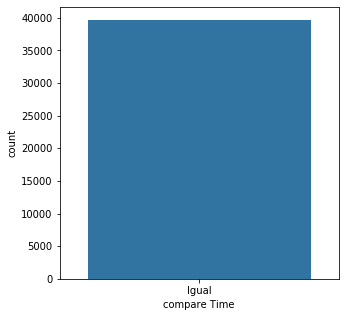

In [176]:
data_vel['compare Time'] = np.where((data_vel['Estampa de tiempo'] == data_amp1X['Estampa de tiempo']), 'Igual', 'Diferente')
# Agrupar los datos por falso o verdadero
plt.figure(figsize=(5, 5))
sns.countplot(data_vel['compare Time'])
# Como todas las fechas coinciden se puede hacer la unión de las tablas
data_vel.drop('compare Time', axis=1, inplace=True)

Se verifica que la referencia angular (KPH) coincida en todas las medidas

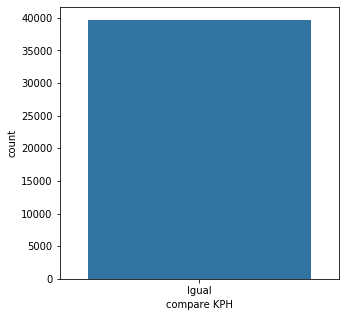

In [177]:
data_vel['compare KPH'] = np.where((data_vel['KPH'] == data_amp1X['KPH']), 'Igual', 'Diferente')
# Agrupar los datos por falso o verdadero
plt.figure(figsize=(5, 5))
sns.countplot(data_vel['compare KPH'])
# Como todas las fechas coinciden se puede hacer la unión de las tablas
data_vel.drop('compare KPH', axis=1, inplace=True)

Se eliminan la componente kph de una de las dos tablas de dato porque es la misma

In [0]:
data_amp1X.drop('KPH', axis=1, inplace=True)

Se cambian los nombres de las tablas de datos para que se distingan y se unen

In [179]:
data_vel.columns = ['TimeStamp', 'KPH', 'DIAG1', 'DIAG2', 'AXI2', 'DIAG3', 'DIAG4']
data_amp1X.columns = ['TimeStamp', 'DIAG1_1X', 'DIAG2_1X', 'AXI2_1X', 'DIAG3_1X', 'DIAG4_1X', 'Falla']

# Se hace una combinación de las tablas para tener una sola
data_vel['DIAG1_1X'] = data_amp1X['DIAG1_1X']
data_vel['DIAG2_1X'] = data_amp1X['DIAG2_1X']
data_vel['AXI2_1X'] = data_amp1X['AXI2_1X']
data_vel['DIAG3_1X'] = data_amp1X['DIAG3_1X']
data_vel['DIAG4_1X'] = data_amp1X['DIAG4_1X']
data_vel['Falla'] = data_amp1X['Falla']
dataTable = data_vel.copy()

print(dataTable.shape)
dataTable.head()

(39666, 13)


,TimeStamp,KPH,DIAG1,DIAG2,AXI2,DIAG3,DIAG4,DIAG1_1X,DIAG2_1X,AXI2_1X,DIAG3_1X,DIAG4_1X,Falla
0,16/04/2019 16:22,0.00,5.309,2.503,0.029,10.931,1.352,0.000000,0.000000,0.000000,0.000000,0.000000,OK
1,16/04/2019 16:22,0.00,5.259,2.456,0.028,10.896,1.587,0.000000,0.000000,0.000000,0.000000,0.000000,OK
2,16/04/2019 16:22,0.00,5.295,2.366,0.022,11.036,1.701,0.000000,0.000000,0.000000,0.000000,0.000000,OK
3,16/04/2019 16:22,0.00,5.359,2.432,0.026,11.022,2.065,0.000000,0.000000,0.000000,0.000000,0.000000,OK
4,16/04/2019 16:23,2621.97,5.401,2.575,0.040,25.400,25.400,1.863805,1.979871,0.197882,91.155264,212.856235,OK


Información de la base de datos: Se ve que la base de datos 39666 registros, además que no hay datos nulos y los datos son tipo float64 excepto la estampa de tiempo y la falla.

In [180]:
dataTable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39666 entries, 0 to 39665
Data columns (total 13 columns):
TimeStamp    39666 non-null object
KPH          39666 non-null float64
DIAG1        39666 non-null float64
DIAG2        39666 non-null float64
AXI2         39458 non-null float64
DIAG3        39666 non-null float64
DIAG4        39666 non-null float64
DIAG1_1X     39666 non-null float64
DIAG2_1X     39666 non-null float64
AXI2_1X      39458 non-null float64
DIAG3_1X     39666 non-null float64
DIAG4_1X     39666 non-null float64
Falla        39666 non-null object
dtypes: float64(11), object(2)
memory usage: 3.9+ MB


Descripción de los datos numéricos de la base de datos

In [181]:
dataTable.describe()

,KPH,DIAG1,DIAG2,AXI2,DIAG3,DIAG4,DIAG1_1X,DIAG2_1X,AXI2_1X,DIAG3_1X,DIAG4_1X
count,39666.000000,39666.000000,39666.000000,39458.000000,39666.000000,39666.000000,39666.000000,39666.000000,39458.000000,39666.000000,39666.000000
mean,3398.255732,3.896145,4.886199,2.938312,6.308209,6.638470,58.840416,84.622809,40.726980,55.816554,34.034825
std,827.906876,2.873748,3.792881,2.781790,5.362376,5.943709,146.578368,211.141279,100.237011,138.511763,116.984521
min,0.000000,0.000000,0.000000,0.000000,0.005000,0.005000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3600.000000,1.683250,1.967250,0.925250,3.311000,2.514000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3600.000000,3.639500,4.286000,2.581000,5.298000,4.732000,1.491833,2.289457,1.276850,1.922508,2.857627
75%,3600.000000,5.876750,7.183000,4.400000,8.232000,9.320000,5.905795,7.705409,4.895388,7.168042,11.839424
max,19726.940000,50.800000,48.895000,34.839000,50.800000,50.800000,1062.762235,1380.647495,646.727708,871.164209,1246.692987


Análisis para la limpieza de datos: 
Se sabe que la velocidad nominal de la máquina es de 3600 RPM, por eso se analiza cuantos valores son menores o mayores con un 1.3%, es decir 50 RPM por encima y 50 RPM por debajo.

In [182]:
#velocidadCero = (dataTable[dataTable['KPH'] == 0].count())['TimeStamp']
velocidadnominal = (dataTable[dataTable['KPH'] == 3600].count())['TimeStamp']

menores = (dataTable[dataTable['KPH'] < 3550].count())['TimeStamp']
mayores = (dataTable[dataTable['KPH'] > 3650].count())['TimeStamp']

print(' Total de datos: ', len(dataTable['KPH']),'\n', 
      'Datos en la velocidad nominal: ', velocidadnominal, '\n',
      #'Total datos en la velocidad nominal: ', round(velocidadnominal/len(dataTable['KPH'])*100),'%', '\n',
      'Datos por debajo de la velocidad nominal: ', menores, '\n',
      'Datos por encima de la velocidad nominal: ', mayores, '\n',
      'Total datos por fuera de la velocidad nominal: ', round((menores+mayores)/len(dataTable['KPH'])*100),'%'
      
      )

 Total de datos:  39666 
 Datos en la velocidad nominal:  29454 
 Datos por debajo de la velocidad nominal:  2303 
 Datos por encima de la velocidad nominal:  38 
 Total datos por fuera de la velocidad nominal:  6.0 %


Se puede observar que el 6% de los datos están por fuera de la velocidad nominal, esto quiere decir que son medidas de la maquina apagada, prendiendo, apagando, o son medidas erroneas. El análisis de las fallas se hace con la máquina en la velocidad nominal, por esto se toma la decición de eliminar estos datos

In [183]:
# Se eliminan los datos por fuera de la velocidad nominal de la máquina
dataTable.drop( dataTable[ dataTable['KPH'] < 3550 ].index , inplace=True)
dataTable.drop( dataTable[ dataTable['KPH'] > 3650 ].index , inplace=True)
# Descripción de los datos numéricos de la base de datos
dataTable.KPH.describe()

count    37325.000000
mean      3600.307669
std          6.592165
min       3553.200000
25%       3600.000000
50%       3600.000000
75%       3600.000000
max       3649.820000
Name: KPH, dtype: float64

Ver la distribución de los datos de la velocidad angular. Se ve que los datos están muy concentrados en 3600 que es la velocidad nominal de la máquina

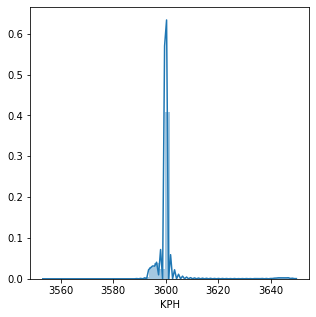

In [184]:
plt.figure(figsize=(5, 5))
sns.distplot(dataTable.KPH)

Se ve que el dataset paso de tener 39666 datos a tener 37325 datos

In [185]:
dataTable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37325 entries, 13 to 39665
Data columns (total 13 columns):
TimeStamp    37325 non-null object
KPH          37325 non-null float64
DIAG1        37325 non-null float64
DIAG2        37325 non-null float64
AXI2         37117 non-null float64
DIAG3        37325 non-null float64
DIAG4        37325 non-null float64
DIAG1_1X     37325 non-null float64
DIAG2_1X     37325 non-null float64
AXI2_1X      37117 non-null float64
DIAG3_1X     37325 non-null float64
DIAG4_1X     37325 non-null float64
Falla        37325 non-null object
dtypes: float64(11), object(2)
memory usage: 4.0+ MB


Ver la distribución las variables diagonales

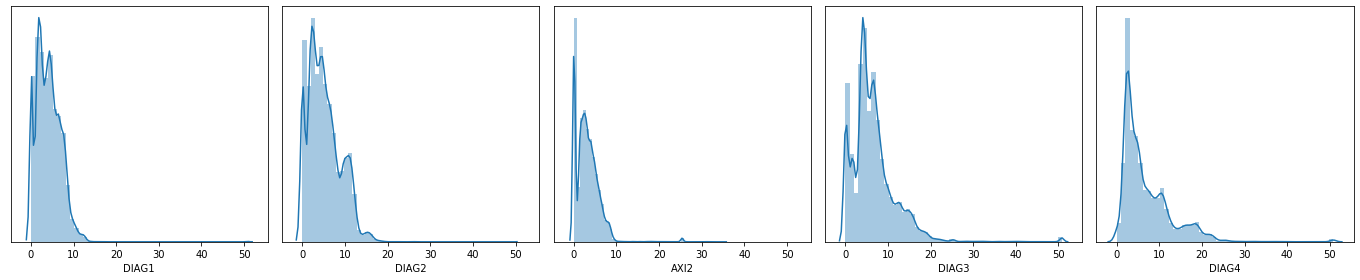

In [186]:
f, axes = plt.subplots(1, 5, figsize=(19, 4), sharex=True)
sns.distplot(dataTable.DIAG1, ax=axes[0])
sns.distplot(dataTable.DIAG2, ax=axes[1])
sns.distplot(dataTable.AXI2, ax=axes[2])
sns.distplot(dataTable.DIAG3, ax=axes[3])
sns.distplot(dataTable.DIAG4, ax=axes[4])
plt.setp(axes, yticks=[])
plt.tight_layout()

El analista de vibraciones determina unos niveles de vibración para cada sensor (deacuerdo con la norma). Esto con el fín de determinar los niveles normales de operación, niveles en condición de alarma, niveles en condición de disparo o datos atípicos.

* DIAG1 Alarma = 5 mm/s2, Disparo = 8 mm/s
* DIAG2 Alarma = 5 mm/s2, Disparo = 8 mm/s
* AXI2 Alarma = 5 mm/s2, Disparo = 8 mm/s
* DIAG3 Alarma = 10 mm/s2, Disparo = 18 mm/s
* DIAG4 Alarma = 10 mm/s2, Disparo = 18 mm/s

Debido a estos valores de vibraciones se pueden determinar un umbral de valores atípicos del sistema


In [187]:
a = (dataTable[dataTable['DIAG1'] > 20].count())['TimeStamp']
b = (dataTable[dataTable['DIAG2'] > 20].count())['TimeStamp']
c = (dataTable[dataTable['AXI2'] > 20].count())['TimeStamp']
d = (dataTable[dataTable['DIAG3'] > 30].count())['TimeStamp']
e = (dataTable[dataTable['DIAG4'] > 30].count())['TimeStamp']

print(' Total de datos: ',len(dataTable['DIAG1']),'\n',
      'Datos atípicos DIAG1: ', a,'\n',
      'Datos atípicos DIAG2: ',b,'\n',
      'Datos atípicos AXI2: ',c,'\n',
      'Datos atípicos DIAG3: ',d,'\n',
      'Datos atípicos DIAG4: ',e,'\n'
      )

 Total de datos:  37325 
 Datos atípicos DIAG1:  9 
 Datos atípicos DIAG2:  18 
 Datos atípicos AXI2:  172 
 Datos atípicos DIAG3:  206 
 Datos atípicos DIAG4:  197 



Se eliminan los datos que son posibles errores

In [188]:
dataTable.drop( dataTable[dataTable['DIAG1'] > 20].index , inplace=True)
dataTable.drop( dataTable[dataTable['DIAG2'] > 20].index , inplace=True)
dataTable.drop( dataTable[dataTable['AXI2'] > 20].index , inplace=True)
dataTable.drop( dataTable[dataTable['DIAG3'] > 30].index , inplace=True)
dataTable.drop( dataTable[dataTable['DIAG4'] > 30].index , inplace=True)
# El dataset paso de tener 39627 datos a tener 38766 dator
dataTable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36809 entries, 13 to 39665
Data columns (total 13 columns):
TimeStamp    36809 non-null object
KPH          36809 non-null float64
DIAG1        36809 non-null float64
DIAG2        36809 non-null float64
AXI2         36601 non-null float64
DIAG3        36809 non-null float64
DIAG4        36809 non-null float64
DIAG1_1X     36809 non-null float64
DIAG2_1X     36809 non-null float64
AXI2_1X      36601 non-null float64
DIAG3_1X     36809 non-null float64
DIAG4_1X     36809 non-null float64
Falla        36809 non-null object
dtypes: float64(11), object(2)
memory usage: 3.9+ MB


Se hace el mismo procedimiento para los niveles de la componente 1X. Niveles de vibración:
* DIAG1 Alarma = 5 mm/s2, Disparo = 8 mm/s
* DIAG2 Alarma = 5 mm/s2, Disparo = 8 mm/s
* AXI2 Alarma = 5 mm/s2, Disparo = 8 mm/s
* DIAG3 Alarma = 10 mm/s2, Disparo = 18 mm/s
* DIAG4 Alarma = 10 mm/s2, Disparo = 18 mm/s

In [189]:
# Debido a estos valores de vibraciones se pueden determinar un umbral de valores atípicos del sistema

a = (dataTable[dataTable['DIAG1_1X'] > 20].count())['TimeStamp']
b = (dataTable[dataTable['DIAG2_1X'] > 20].count())['TimeStamp']
c = (dataTable[dataTable['AXI2_1X'] > 20].count())['TimeStamp']
d = (dataTable[dataTable['DIAG3_1X'] > 30].count())['TimeStamp']
e = (dataTable[dataTable['DIAG4_1X'] > 30].count())['TimeStamp']

print(' Total de datos: ',len(dataTable['DIAG1']),'\n',
      'Datos atípicos DIAG1_1X: ', a,'\n',
      'Datos atípicos DIAG2_1X: ',b,'\n',
      'Datos atípicos AXI2_1X: ',c,'\n',
      'Datos atípicos DIAG3_1X: ',d,'\n',
      'Datos atípicos DIAG4_1X: ',e,'\n'
      )

 Total de datos:  36809 
 Datos atípicos DIAG1_1X:  6063 
 Datos atípicos DIAG2_1X:  6063 
 Datos atípicos AXI2_1X:  6063 
 Datos atípicos DIAG3_1X:  6108 
 Datos atípicos DIAG4_1X:  4725 



Se eliminan los datos que son posibles errores

In [190]:
dataTable.drop( dataTable[dataTable['DIAG1_1X'] > 20].index , inplace=True)
dataTable.drop( dataTable[dataTable['DIAG2_1X'] > 20].index , inplace=True)
dataTable.drop( dataTable[dataTable['AXI2_1X'] > 20].index , inplace=True)
dataTable.drop( dataTable[dataTable['DIAG3_1X'] > 30].index , inplace=True)
dataTable.drop( dataTable[dataTable['DIAG4_1X'] > 30].index , inplace=True)
# El dataset paso de tener 38766 datos a tener 31620 dator
dataTable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29673 entries, 13 to 39665
Data columns (total 13 columns):
TimeStamp    29673 non-null object
KPH          29673 non-null float64
DIAG1        29673 non-null float64
DIAG2        29673 non-null float64
AXI2         29465 non-null float64
DIAG3        29673 non-null float64
DIAG4        29673 non-null float64
DIAG1_1X     29673 non-null float64
DIAG2_1X     29673 non-null float64
AXI2_1X      29465 non-null float64
DIAG3_1X     29673 non-null float64
DIAG4_1X     29673 non-null float64
Falla        29673 non-null object
dtypes: float64(11), object(2)
memory usage: 3.2+ MB


Se eliminan los datos que son cero. Esto porque hay ausencia de medida y no es útil para el análisis de vibraciones.

In [191]:
dataTable.drop( dataTable[dataTable['DIAG1'] == 0].index , inplace=True)
dataTable.drop( dataTable[dataTable['DIAG2'] == 0].index , inplace=True)
dataTable.drop( dataTable[dataTable['AXI2'] == 0].index , inplace=True)
dataTable.drop( dataTable[dataTable['DIAG3'] == 0].index , inplace=True)
dataTable.drop( dataTable[dataTable['DIAG4'] == 0].index , inplace=True)
dataTable.drop( dataTable[dataTable['DIAG1_1X'] == 0].index , inplace=True)
dataTable.drop( dataTable[dataTable['DIAG2_1X'] == 0].index , inplace=True)
dataTable.drop( dataTable[dataTable['AXI2_1X'] == 0].index , inplace=True)
dataTable.drop( dataTable[dataTable['DIAG3_1X'] == 0].index , inplace=True)
dataTable.drop( dataTable[dataTable['DIAG4_1X'] == 0].index , inplace=True)
# El dataset paso de tener 31620 datos a tener 19027 dator
dataTable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19027 entries, 102 to 39665
Data columns (total 13 columns):
TimeStamp    19027 non-null object
KPH          19027 non-null float64
DIAG1        19027 non-null float64
DIAG2        19027 non-null float64
AXI2         19027 non-null float64
DIAG3        19027 non-null float64
DIAG4        19027 non-null float64
DIAG1_1X     19027 non-null float64
DIAG2_1X     19027 non-null float64
AXI2_1X      19027 non-null float64
DIAG3_1X     19027 non-null float64
DIAG4_1X     19027 non-null float64
Falla        19027 non-null object
dtypes: float64(11), object(2)
memory usage: 2.0+ MB


Ver la distribución de las componenetes 1X de cada sensor

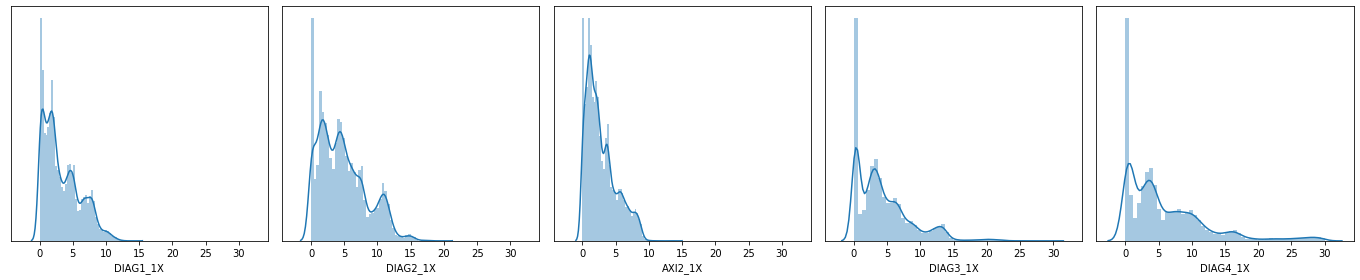

In [192]:
f, axes = plt.subplots(1, 5, figsize=(19, 4), sharex=True)
sns.distplot(dataTable.DIAG1_1X, ax=axes[0])
sns.distplot(dataTable.DIAG2_1X, ax=axes[1])
sns.distplot(dataTable.AXI2_1X, ax=axes[2])
sns.distplot(dataTable.DIAG3_1X, ax=axes[3])
sns.distplot(dataTable.DIAG4_1X, ax=axes[4])
plt.setp(axes, yticks=[])
plt.tight_layout()

Ahora se hace el análisis de las fallas que se presentaron en la máquina. Cabe anotar que en diferentes momentos la máquina no presenta falla, entonces la condición 'OK' representa que el activo está en buenas condiciones.

In [193]:
# Suma del las fallas
dataTable.Falla.value_counts()

OK                 10154
SoltEst_BM          3463
SoltEst_BChumP4     3277
SoltEst_BChumP3     1234
Desb_Molino          704
Desal_Acople          84
HolgEjeAg_ChuP3       66
HolgEjeAg_ChuP4       45
Name: Falla, dtype: int64

Se grafica el número de falas del sistema.

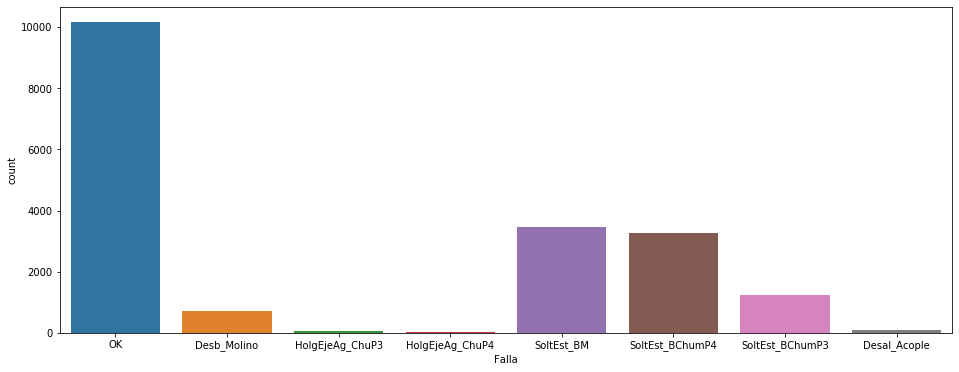

In [194]:
# Agrupar los compradores por falla
plt.figure(figsize=(16, 6))
sns.countplot(dataTable['Falla'])

Se mapean las variables categóricas a numéricas. Esto para poder ingresar los datos a un algoritmo de Aprendizaje de Máquinas y poder generar un modelo de clasificación.

In [195]:
label = dataTable['Falla']
dataTable['objetivo'] = dataTable['Falla'].map({'OK':0 , 'SoltEst_BM':1 , 'SoltEst_BChumP4':2 , 'SoltEst_BChumP3': 3,
                                                'Desb_Molino': 4, 'Desal_Acople': 5, 'HolgEjeAg_ChuP3': 6,
                                                'HolgEjeAg_ChuP4': 7
                                               })
dataTable.drop('Falla', axis=1,inplace = True)
dataTable.tail()

,TimeStamp,KPH,DIAG1,DIAG2,AXI2,DIAG3,DIAG4,DIAG1_1X,DIAG2_1X,AXI2_1X,DIAG3_1X,DIAG4_1X,objetivo
39661,11/03/2020 12:21,3643.08,2.308,2.345,1.412,3.494,3.056,2.108706,2.140130,1.075351,3.295711,2.702272,0
39662,11/03/2020 12:31,3641.33,2.305,2.332,1.461,3.525,3.156,2.092637,2.061598,1.128532,3.357684,2.834543,0
39663,11/03/2020 12:41,3641.74,2.427,2.538,1.495,3.549,3.080,2.155926,2.230390,1.116503,3.355398,2.726889,0
39664,11/03/2020 12:51,3614.59,5.088,5.642,2.612,4.898,4.740,4.957460,5.557554,2.365976,4.018572,4.201773,0
39665,11/03/2020 13:01,3641.33,2.187,2.178,1.318,3.458,3.010,2.103377,1.914562,1.055041,3.212428,2.666135,0


Se elimina la estampa de tiempo y velocidad Angular

In [196]:
dataTable.drop('TimeStamp', axis=1,inplace = True)
dataTable.drop('KPH', axis=1,inplace = True)
dataTable.tail()

,DIAG1,DIAG2,AXI2,DIAG3,DIAG4,DIAG1_1X,DIAG2_1X,AXI2_1X,DIAG3_1X,DIAG4_1X,objetivo
39661,2.308,2.345,1.412,3.494,3.056,2.108706,2.140130,1.075351,3.295711,2.702272,0
39662,2.305,2.332,1.461,3.525,3.156,2.092637,2.061598,1.128532,3.357684,2.834543,0
39663,2.427,2.538,1.495,3.549,3.080,2.155926,2.230390,1.116503,3.355398,2.726889,0
39664,5.088,5.642,2.612,4.898,4.740,4.957460,5.557554,2.365976,4.018572,4.201773,0
39665,2.187,2.178,1.318,3.458,3.010,2.103377,1.914562,1.055041,3.212428,2.666135,0


In [197]:
# Suma del resultado de los objetivos (numéricos) 
dataTable.objetivo.value_counts()

0    10154
1     3463
2     3277
3     1234
4      704
5       84
6       66
7       45
Name: objetivo, dtype: int64

## MODELOS DE CLASIFICACIÓN

**ÁRBOL DE DECISIÓN**

Se divide el dataSet en la componente X o características y la componente Y que es el objetivo de clasificación.

In [198]:
# Se crean las variables X y Y
X = dataTable.drop('objetivo', 1)
Y = dataTable.objetivo
print(X.shape, Y.shape)

(19027, 10) (19027,)


Se separa la base de datos entre datos de entrenamiento y datos de pruebas (80% - 20%)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

Modelo de árbol de decisión profundidad = 2. Se puede observar que el modelo obtuvo una medida de desempeño de 0.8 tanto en el entrenamiento como el la prueba.

In [200]:
modelo1 = tree.DecisionTreeClassifier(random_state=1, max_depth=2)
modelo1.fit(x_train, y_train)
modelo1_score_train = modelo1.score(x_train, y_train)
print("Training score: ",modelo1_score_train)
modelo1_score_test = modelo1.score(x_test, y_test)
print("Testing score: ",modelo1_score_test)

Training score:  0.8100650417186781
Testing score:  0.8092485549132948


Se imprime el árbol

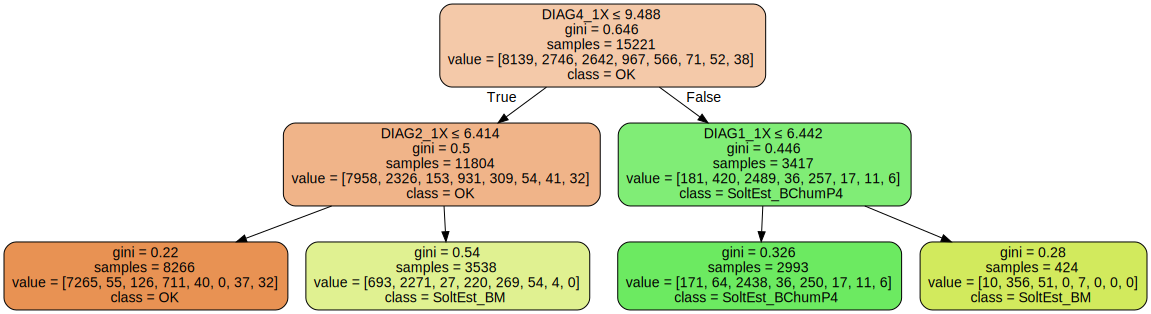

In [201]:
features_names = X.columns.tolist()
classes_names = ['OK', 'SoltEst_BM', 'SoltEst_BChumP4', 'SoltEst_BChumP3', 'Desb_Molino', 'Desal_Acople']

# Configurar el tamaño de la gráfica
rcParams['figure.figsize'] = 10,10

Arbol = tree.export_graphviz(modelo1, out_file=None, 
                      feature_names=features_names,  
                      class_names=classes_names,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(Arbol)  
graph

Mirar las características más importantes. Se puede observar que DIAG2_1X y DIAG4_1X son las más importantes. 

In [202]:
features = X.columns.tolist()
fi = modelo1.feature_importances_
l = len(features)
for i in range(0,len(features)):
    print('{:.<20} {:3}'.format(features[i],fi[i]))

DIAG1............... 0.0
DIAG2............... 0.0
AXI2................ 0.0
DIAG3............... 0.0
DIAG4............... 0.0
DIAG1_1X............ 0.08575107598822193
DIAG2_1X............ 0.43298633621850047
AXI2_1X............. 0.0
DIAG3_1X............ 0.0
DIAG4_1X............ 0.4812625877932777


Se hace la visialización de una una de las variables más importantes (DIAG4_1X) con respecto al punto de decisión del árbol (9.488)

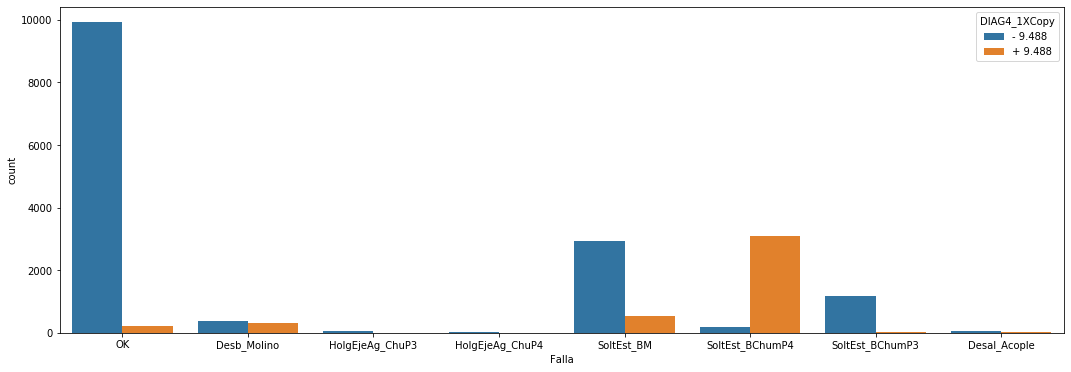

In [203]:
# Se hace una copia de una una de las variables más importantes
dataTable['DIAG4_1XCopy'] = dataTable['DIAG4_1X'].copy()

# De acuerdo al arbol de decisión se hace un mapeo en el valor de decisión
# Si la amplitud de DIAG1_1X es menor o igual de 9.488 mm/s2 se marca como - 9.488, sino como + 9.488
dataTable['DIAG4_1XCopy'] = dataTable['DIAG4_1XCopy'].map(lambda x: '- 9.488' if x <= 9.488 else '+ 9.488')

# Agrupar por respuesta final y duración de la llamada
#label = data_amp1X.Falla
#label = dataTable.objetivo
plt.figure(figsize=(18, 6))
sns.countplot(label,hue=dataTable['DIAG4_1XCopy'])

# Se elimina la comuna durationTime
dataTable.drop(columns = ["DIAG4_1XCopy"],inplace=True)

Se hace la visialización de una una de las variables más importantes (DIAG2_1X) con respecto al punto de decisión del árbol (6.414)

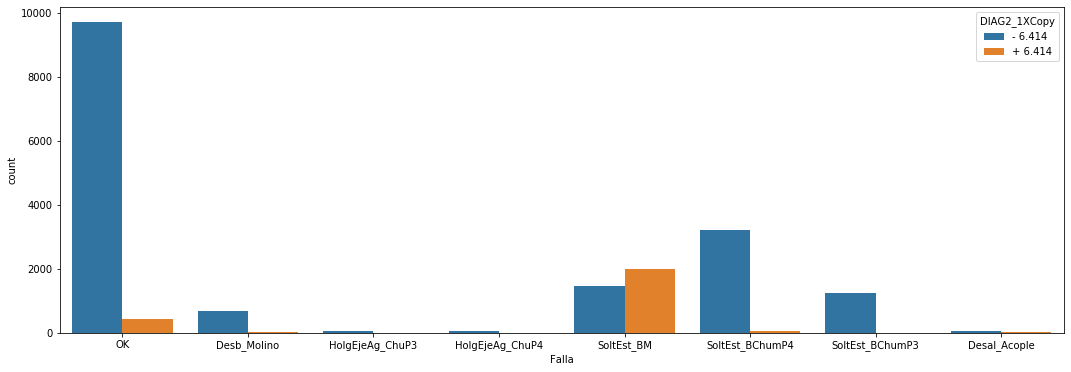

In [204]:
# Se hace una copia de una de las 3 variables más importantes
dataTable['DIAG2_1XCopy'] = dataTable['DIAG2_1X'].copy()

# De acuerdo al arbol de decisión se hace un mapeo en el valor de decisión
# Si la amplitud de DIAG1_1X es menor o igual de 9.488 mm/s2 se marca como - 6.414, sino como + 6.414
dataTable['DIAG2_1XCopy'] = dataTable['DIAG2_1XCopy'].map(lambda x: '- 6.414' if x <= 9.488 else '+ 6.414')

# Agrupar por respuesta final y duración de la llamada
#label = dataTable.objetivo
plt.figure(figsize=(18, 6))
sns.countplot(label,hue=dataTable['DIAG2_1XCopy'])

# Se elimina la comuna durationTime
dataTable.drop(columns = ["DIAG2_1XCopy"],inplace=True)

Ahora se crear otro modelo de Árbol de Decisión con profundidad = 5.

In [205]:
# Árbol de decisión profundidad = 5
modelo2 = tree.DecisionTreeClassifier(random_state=1, max_depth=5)
modelo2.fit(x_train, y_train)
modelo2_score_train = modelo2.score(x_train, y_train)
print("Training score: ",modelo2_score_train)
modelo2_score_test = modelo2.score(x_test, y_test)
print("Testing score: ",modelo2_score_test)

Training score:  0.8997437750476316
Testing score:  0.8896479243300053


Se imprimir el modelo del árbol

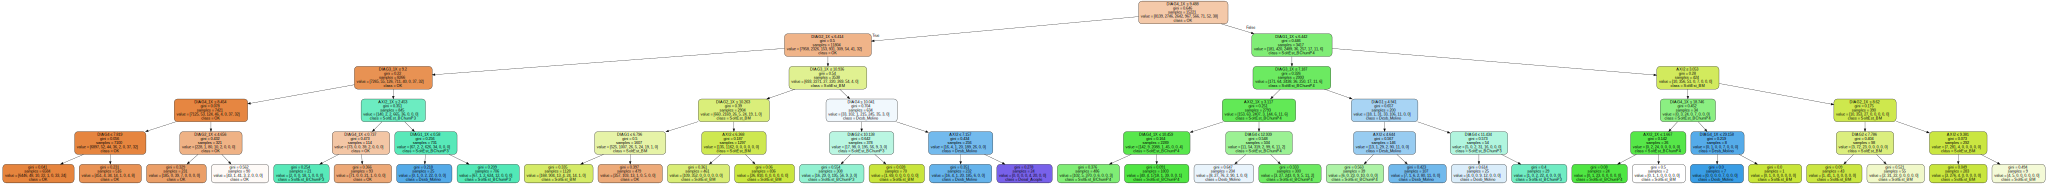

In [206]:
# Se imprime el árbol
Arbol = tree.export_graphviz(modelo2, out_file=None, 
                      feature_names=features_names,  
                      class_names=classes_names,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(Arbol) 
graph 

Mirar las características más importantes de este árbol. Se puede observar que las decisiónes están más distribuidas en las características. La componente DIAG3 no aporta nada a la decisión y las componentes DIAG2_1X y DIAG4_1X siguen siendo las más importantes.

In [207]:
features = X.columns.tolist()
fi = modelo2.feature_importances_

l = len(features)
for i in range(0,len(features)):
    print('{:.<20} {:3}'.format(features[i],fi[i]))

DIAG1............... 0.03444084854386727
DIAG2............... 0.010521069666573965
AXI2................ 0.013854169697269
DIAG3............... 0.0
DIAG4............... 0.020181545436523254
DIAG1_1X............ 0.0630938120200506
DIAG2_1X............ 0.30997127574586214
AXI2_1X............. 0.014570982085524464
DIAG3_1X............ 0.1924396583823703
DIAG4_1X............ 0.34092663842195897


Se crear otro modelo de Árbol de Decisión con máxima profundidad.

In [208]:
# Árbol de decisión completamente profunda
modelo5 = tree.DecisionTreeClassifier()
modelo5.fit(x_train, y_train)
modelo5_score_train = modelo5.score(x_train, y_train)
print("Training score: ", modelo5_score_train)
modelo5_score_test = modelo5.score(x_test, y_test)
print("Testing score: ", modelo5_score_test)

Training score:  1.0
Testing score:  0.8794009458749343


Se compara los modelos y determinar cual de los 3 es el mejor.

In [209]:
# Comparación de los modelos exactitud

print('{:10} {:20} {:20}'.format('Profundidad', 'Desempeño entrenamiento','Desempeño prueba'))
print('{:10} {:20} {:20}'.format('-----------', '-----------------------','----------------'))
print('{:1} {:>25} {:>20}'.format(2, modelo1_score_train, modelo1_score_test))
print('{:1} {:>25} {:>20}'.format(5, modelo2_score_train, modelo2_score_test))
print('{:1} {:>23} {:>20}'.format("max", modelo5_score_train, modelo5_score_test))

Profundidad Desempeño entrenamiento Desempeño prueba    
----------- ----------------------- ----------------    
2        0.8100650417186781   0.8092485549132948
5        0.8997437750476316   0.8896479243300053
max                     1.0   0.8794009458749343


Se podría ver que, a mayor profundidad, el puntaje de desempeño aumenta. El árbol de profundidad máxima se sobreentrenó pues obtuvo un puntaje de 1.0 en el entrenamiento pero en el puntaje de prueba fue menor. Según las observaciones anteriores, el árbol con una profundidad de 5 parece ser el modelo más razonable, ya que tanto los puntajes de entrenamiento como de prueba son altos.

**RANDOM FOREST**

Debido al sobreentrenamiento se prueba un modelo con Bosqueas aleatorios, es decir, una serie de árboles de decisión. Este modelo tiena la capacidad de partir el data set aleatoriamente y asignarlo a árboles de decisión diferentes y finalmente realiza un promeido para verificar cual de todos los árboles es el mejor. La aleatoriedad de entrenamiento de los árboles elimina el sobreentrenamiento.

Se entrena el modelo

In [210]:
model = RandomForestClassifier(n_estimators=1000)
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [211]:
y_pred = model.predict(x_test)
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      2007
           1       0.90      0.92      0.91       699
           2       0.93      0.89      0.91       664
           3       0.87      0.85      0.86       273
           4       0.75      0.76      0.76       137
           5       0.54      0.44      0.48        16
           6       0.21      1.00      0.35         3
           7       0.57      0.57      0.57         7

    accuracy                           0.92      3806
   macro avg       0.72      0.80      0.72      3806
weighted avg       0.92      0.92      0.92      3806



Se visualiza la matriz de confusión. Esta matriz nos permite hacer una relación de los datos que eran de determinada clase y el los clasificó en esa misma clase o en otra diferente. La diagonal principal es el objetivo de un buen modelo, los demás datos son errores en la predicción.

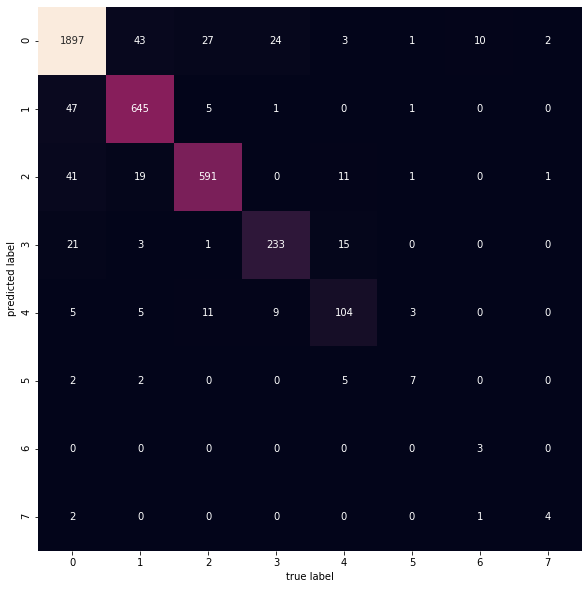

In [212]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');